In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from tqdm import tqdm
import glob
from pathlib import Path as P
import cv2
import time

path_root = "/media/yui/Disk/data/semantic_drone_dataset"
path_color = "training_set/gt/semantic/class_dict.csv"
path_gt = "training_set/gt/semantic/label_images"
path_inp = "training_set/images"

In [2]:
print(tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


In [5]:
class Data:    
    def __init__(self,path_root,path_color,
                path_gt,path_inp):
        self.path_root = path_root
        self.path_color = path_color
        self.path_gt = path_gt
        self.path_inp = path_inp
        self.id2name,self.id2color,\
            self.color2id = self.colorExtract()
        ids = os.listdir(str(P(path_root)/P(path_inp)))
        self.ids = list(map(lambda x:x.replace(".jpg",""),ids))
    def colorExtract(self):
        df = pd.read_csv(str(P(self.path_root)/P(self.path_color)))
        id2name,id2color,color2id = {},{},{}
        for i in range(df.shape[0]):
            id2name[i] = df.iloc[i]['name']
            color = (df.iloc[i][' r'],
                df.iloc[i][' g'],df.iloc[i][' b'])
            id2color[i] = color
            color2id[color] = i
        return id2name,id2color,color2id
    @staticmethod
    def rgb2oneHot(img,id2color):
        new_shp = img.shape[:2]+(len(id2color),)
        new_img = np.zeros(new_shp)
        for i,cls in enumerate(id2color):
            new_img[:,:,i] = np.all(img.reshape((-1,\
                            3))==id2color[i],\
                            axis=1).reshape(new_shp[:2])
        return new_img
    def load(self,idname):
        inp = cv2.imread(str(P(self.path_root)/\
                P(self.path_inp)/\
                P(f"{idname}.jpg")))[:,:,::-1]
        gt = cv2.imread(str(P(self.path_root)/\
                P(self.path_gt)/\
                P(f"{idname}.png")))[:,:,::-1]
        return inp,gt
    @staticmethod
    def resize(inp,gt,h,w):
        inp = tf.image.resize(inp,[h,w],
                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        gt = tf.image.resize(gt,[h,w],
                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        return inp,gt
    @staticmethod
    def random_crop(inp,gt,h,w):
        stack = tf.stack([inp,gt],axis=0)
        crop = tf.image.random_crop(
            stack,size=[2,h,w,3])
        return crop[0],crop[1]
    @staticmethod
    def visImg(img):
        plt.imshow(img)
        plt.axis("off")
    @staticmethod
    @tf.function()
    def random_jitter(inp,gt):
        inp,gt = Data.resize(inp,gt,286,286)
        inp,gt = Data.random_crop(inp,gt,256,256)
        if tf.random.uniform(())>0.5:
            inp = tf.image.flip_left_right(inp)
            gt = tf.image.flip_left_right(gt)
        if tf.random.uniform(())>0.5:
            inp = tf.image.flip_up_down(inp)
            gt = tf.image.flip_up_down(gt)
        return inp,gt
    @staticmethod
    def normalize(inp,gt):
        inp = inp/127.5-1
        return inp,gt
    
dataCls = Data(path_root,path_color,path_gt,path_inp)


In [6]:
t1 = time.time()
for i_ in tqdm(dataCls.ids):
    inp,gt = dataCls.load(i_)
    inp_,gt_ = Data.random_jitter(inp,gt)
    _ = Data.rgb2oneHot(gt_.numpy(),dataCls.id2color)
t2 = time.time()
print("Time required for all images: ",t2-t1)
print("Read per second: ",(t2-t1)/len(dataCls.ids))

100%|██████████| 400/400 [05:33<00:00,  1.20it/s]

Time required for all images:  333.06831765174866
Read per second:  0.8326707941293716


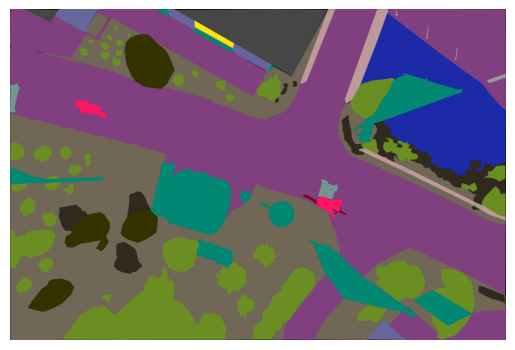

In [7]:
dataCls.visImg(gt)
plt.show()

In [8]:
gt_.shape

TensorShape([256, 256, 3])

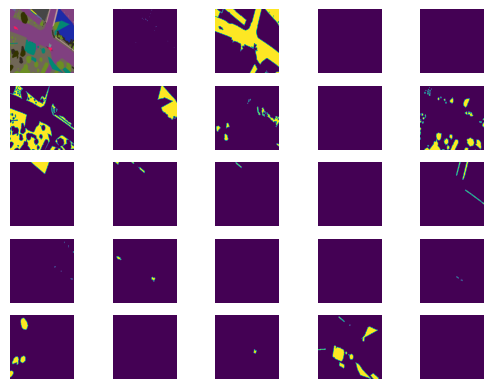

In [9]:
oneHot = Data.rgb2oneHot(gt_.numpy(),dataCls.id2color)
plt.subplot(5,5,1)
plt.imshow(gt_)
plt.axis('off')
for i in range(24):
    plt.subplot(5,5,i+2)
    plt.imshow(oneHot[:,:,i])
    plt.axis('off')
plt.show()

### Convolutional Layer with Same Padding
$$ n'=\frac{n-f+2p}{s}+1 $$
- Same padding means $p=1$, we can scale down the layer by $s$, where $s$ is the stride but also a multiple of 2, 

$$\begin{align*}
\frac{n}{s} &= \frac{n-f+2}{s}+1 \\
\frac{n-s}{s} &= \frac{n-f+2}{s} \\ 
n-s &= n-f+2 \\
f &= s+2
\end{align*}$$


In [20]:
class Model:
    def __init__(self):
        pass
    @staticmethod
    def downsample(c,f,s,batchnorm=True):
        init = tf.random_normal_initializer(0,.02)
        res = tf.keras.Sequential()
        res.add(
            tf.keras.layers.Conv2D(c,f,strides=s,
                padding="same",kernel_initializer=init,
                use_bias=False)
        )
        if batchnorm:
            res.add(tf.keras.layers.BatchNormalization())
        res.add(tf.keras.layers.LeakyReLU())
        return res
    @staticmethod
    def downsampleByN(c,s,batchnorm=True):
        return Model.downsample(c,s+2,s,batchnorm)
    @staticmethod
    def upsample(c,f,s,dropout=False):
        init = tf.random_normal_initializer(0,.02)
        res = tf.keras.Sequential()
        res.add(
            tf.keras.layers.Conv2DTranspose(c,f,strides=s,
                padding="same",kernel_initializer=init,
                use_bias=False)
        )
        if dropout:
            res.add(tf.keras.layers.Dropout(.5))
        res.add(tf.keras.layers.ReLU())
        return res
    @staticmethod
    def upsampleByN(c,s,dropout=False):
        return Model.upsample(c,s+2,s,dropout)
#     @staticmethod
#     def UNet(scale,shp):
#         inputs = tf.keras.layers.Input(shape=shp)
#         dim = shp[0]
        
#         downs = [
#             Model.downsampleByN()
#             for i in range(int(np.log(dim)/np.log(scale)))
#         ]

In [32]:
def UNet(o=24,s=4):
    inputs = tf.keras.layers.Input(shape=[256,256,3])
    downs = [
        Model.downsampleByN(64,s,batchnorm=False),
        Model.downsampleByN(128,s),
        Model.downsampleByN(256,s),
        Model.downsampleByN(512,s),
    ]
    ups = [
        Model.upsampleByN(256,s,dropout=True),
        Model.upsampleByN(128,s,dropout=True),
        Model.upsampleByN(64,s,dropout=True),
    ]
    init = tf.random_normal_initializer(0,.02)
    last = tf.keras.layers.Conv2DTranspose(o,s+2,s,
            padding="same",kernel_initializer=init,
            activation="sigmoid")
    x = inputs
    skips = []
    for d in downs:
        x = d(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    for u,s in zip(ups,skips):
        x = u(x)
        x = tf.keras.layers.Concatenate()([x,s])
    x = last(x)
    return tf.keras.Model(inputs=inputs,outputs=x)

In [33]:
model = UNet()

In [41]:
ds = tf.data.Dataset.from_tensor_slices(\
        list(map(lambda x:int(x),dataCls.ids)))
ds = ds.shuffle(buffer_size=10)
for ele in ds:
    print(ele)
    print("{0:03}".format(ele))

tf.Tensor(112, shape=(), dtype=int32)
112
tf.Tensor(141, shape=(), dtype=int32)
141
tf.Tensor(181, shape=(), dtype=int32)
181
tf.Tensor(128, shape=(), dtype=int32)
128
tf.Tensor(378, shape=(), dtype=int32)
378
tf.Tensor(244, shape=(), dtype=int32)
244
tf.Tensor(531, shape=(), dtype=int32)
531
tf.Tensor(434, shape=(), dtype=int32)
434
tf.Tensor(56, shape=(), dtype=int32)
056
tf.Tensor(258, shape=(), dtype=int32)
258
tf.Tensor(345, shape=(), dtype=int32)
345
tf.Tensor(435, shape=(), dtype=int32)
435
tf.Tensor(517, shape=(), dtype=int32)
517
tf.Tensor(260, shape=(), dtype=int32)
260
tf.Tensor(78, shape=(), dtype=int32)
078
tf.Tensor(104, shape=(), dtype=int32)
104
tf.Tensor(324, shape=(), dtype=int32)
324
tf.Tensor(95, shape=(), dtype=int32)
095
tf.Tensor(318, shape=(), dtype=int32)
318
tf.Tensor(209, shape=(), dtype=int32)
209
tf.Tensor(479, shape=(), dtype=int32)
479
tf.Tensor(26, shape=(), dtype=int32)
026
tf.Tensor(556, shape=(), dtype=int32)
556
tf.Tensor(526, shape=(), dtype=int32)
